# Setup


In [1]:

import pandas as pd
from data_getters import load_s3_data

BUCKET_NAME = "dsp-tutorials"

## Explore and clean data

# Data preparation

For today, we're using a cleaned dataset, to focus on data generation and not data cleaning. However, the cleaning steps are described FYI below, and code used to clean the dataset can be found here (dap_tutorials/synth_data_demo/preprocessing_df.py):

1. The synthetic data generators will mimic all statistical relationships they can find in the data. So:
    - Drop any numeric 'ids' in the data, unless the ordering of the observations matters! It will really eat into the fidelity of the data if the generator tries to mimic the ordering of the ids
    - Make sure you change any 'numeric' categorical variables to strings, to ensure they are treated as non-ordered variables. Whilst you can just define the datatype, I found this was a bit buggy. It was easier to just replace numbers with letters in the data. 


2. 'Missingness' in this context is an important statistical feature that we want to preserve. However, the many packages  won't accept nan values:
    - For categorical variables, we can just replace nan with a new category ('NA' for example)
    - For continuous variable, we need to impute values to maintain the original statistical properties of the variable, and then create a new binary column that indicates if the original value was missing (so that the generator learns both the correct statistical relationships, and the 'missingness' pattern)

3. Some generators struggle with a large number of categories within a single variable. So take note of how many categories there are - if you have issues with training a model later on, this will be a good place to start optimising. 

4. Maybe goes without saying, but:
    - You can't generate synthetic free text fields (eg, comments from a survey) with tabular data generation methods, like we're using today.  So drop any before you start.
    - All var types need to reflect the data type (numbers are ints or floats, categorical variables are bools or objects)
    
5. There is a tradeoff of how well statistical relationships are preserved (think of it like allocating a 'fidelity buget' across different variables). If there are columns that are really irrelevant to your analysis or final dataset, you could drop them before you start (although be very careful doing this, in case it's a confounding variable).Alternatively, there are methods that allow you to nominate the priority fields (although we aren't using them today). 

In [2]:
#Import the cleaned data and explore

#Load pre-cleaned dataset from S3 (we will create a synthetic version from this)

#orig_df = load_s3_data(BUCKET_NAME,'synthetic_data_generation/magic_breakfast_cleaned_data.csv')
orig_df = pd.read_csv('/Users/clare.brennan/Documents/Github_projects/asf_eef_synth_data/inputs/data/magic_breakfast/magic_breakfast_cleaned_data.csv', keep_default_na=False)


print('DataFrame columns:', orig_df.columns)
print('DataFrame shape:', orig_df.shape)

DataFrame columns: Index(['Block_ID_1', 'Anon_School_ID', 'Pupil_Gender', 'Pupil_FSM',
       'Pupil_FSM6', 'Treatment_Allocation', 'PreTest_PupilYeargroup',
       'PostTest_PupilYeargroup', 'PostTest_Outcome_1', 'PostTest_Outcome_2',
       'PostTest_Outcome_3', 'PostTest_Outcome_4', 'PostTest_Outcome_5',
       'PostTest_Outcome_6', 'Included_Final_Analysis', 'School_Context_1',
       'School_Context_2', 'School_Context_3', 'School_Context_4',
       'PreTest_Outcome_FSP', 'PreTest_Outcome_KS1',
       'PostTest_PupilYeargroup_m', 'PostTest_Outcome_1_m',
       'PostTest_Outcome_2_m', 'PostTest_Outcome_3_m', 'PostTest_Outcome_4_m',
       'PostTest_Outcome_5_m', 'PostTest_Outcome_6_m', 'School_Context_1_m',
       'School_Context_2_m', 'School_Context_3_m', 'School_Context_4_m',
       'PreTest_Outcome_FSP_m', 'PreTest_Outcome_KS1_m'],
      dtype='object')
DataFrame shape: (9900, 34)


In [3]:
display(orig_df.head())

,Block_ID_1,Anon_School_ID,Pupil_Gender,Pupil_FSM,Pupil_FSM6,Treatment_Allocation,PreTest_PupilYeargroup,PostTest_PupilYeargroup,PostTest_Outcome_1,PostTest_Outcome_2,...,PostTest_Outcome_3_m,PostTest_Outcome_4_m,PostTest_Outcome_5_m,PostTest_Outcome_6_m,School_Context_1_m,School_Context_2_m,School_Context_3_m,School_Context_4_m,PreTest_Outcome_FSP_m,PreTest_Outcome_KS1_m
0,0.0,52,1.0,0.0,NA,1.0,1,2,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1.0,3,1.0,0.0,0.0,0.0,1,2,0,0,...,0,1,1,0,0,0,0,0,1,0
2,1.0,34,2.0,0.0,0.0,0.0,0,6,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1.0,25,2.0,0.0,1.0,1.0,0,2,1,-1,...,0,0,0,0,0,0,0,0,1,0
4,0.0,46,1.0,1.0,1.0,1.0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
orig_df.dtypes

Block_ID_1                   object
Anon_School_ID                int64
Pupil_Gender                 object
Pupil_FSM                    object
Pupil_FSM6                   object
Treatment_Allocation         object
PreTest_PupilYeargroup        int64
PostTest_PupilYeargroup       int64
PostTest_Outcome_1            int64
PostTest_Outcome_2            int64
PostTest_Outcome_3            int64
PostTest_Outcome_4            int64
PostTest_Outcome_5            int64
PostTest_Outcome_6            int64
Included_Final_Analysis       int64
School_Context_1              int64
School_Context_2              int64
School_Context_3              int64
School_Context_4              int64
PreTest_Outcome_FSP           int64
PreTest_Outcome_KS1           int64
PostTest_PupilYeargroup_m     int64
PostTest_Outcome_1_m          int64
PostTest_Outcome_2_m          int64
PostTest_Outcome_3_m          int64
PostTest_Outcome_4_m          int64
PostTest_Outcome_5_m          int64
PostTest_Outcome_6_m        

In [5]:
orig_df.isna().sum()

Block_ID_1                   0
Anon_School_ID               0
Pupil_Gender                 0
Pupil_FSM                    0
Pupil_FSM6                   0
Treatment_Allocation         0
PreTest_PupilYeargroup       0
PostTest_PupilYeargroup      0
PostTest_Outcome_1           0
PostTest_Outcome_2           0
PostTest_Outcome_3           0
PostTest_Outcome_4           0
PostTest_Outcome_5           0
PostTest_Outcome_6           0
Included_Final_Analysis      0
School_Context_1             0
School_Context_2             0
School_Context_3             0
School_Context_4             0
PreTest_Outcome_FSP          0
PreTest_Outcome_KS1          0
PostTest_PupilYeargroup_m    0
PostTest_Outcome_1_m         0
PostTest_Outcome_2_m         0
PostTest_Outcome_3_m         0
PostTest_Outcome_4_m         0
PostTest_Outcome_5_m         0
PostTest_Outcome_6_m         0
School_Context_1_m           0
School_Context_2_m           0
School_Context_3_m           0
School_Context_4_m           0
PreTest_

## Synthetic data model - Maximum Spanning Tree

* MST is a graph-based method for generating tabular synthetic data. It finds the marginal distribution for variables in the sample (the probability that a value occurs for a single variable, independent of the other variables). 
* Then, it adds some noise to the marginal distribution (this is the step that introduces DP; and the amount of noise is controlled by the privacy threshold ). 
* Finally, it generates synthetic data that preserves the marginal distributions.
* Pros: 
    - High fidelity method
    - Auditable (not a black box model)
    - Can allocate the privacy budget to specific variables, enabling greater preservation of some relationships, and more noise in others
* Cons: 
    - Requires discrete values (like all graph-based methods), so any continuous variables would need to be converted to discrete categories before generating synthetic data. However, the method is able to take such a high number of discrete values that data can be ‘binned’ (grouped together) into very small ranges (it was still an effective method on the UK census, with a number of continuous variables including ages and dates, with 55 million observations each). 
    - Slightly more of a manual process to set up than some other methods, as you need to define the privacy budget for each variable.


In [6]:
from datetime import datetime
import json
import numpy as np
import os
import pandas as pd
from scipy import sparse

from mbi import Dataset, FactoredInference, Domain

/Users/clare.brennan/miniconda3/envs/synth_data_demo/lib/python3.8/site-packages/mbi/__init__.py:17: UserWarning: MixtureInference disabled, please install jax and jaxlib
  warnings.warn("MixtureInference disabled, please install jax and jaxlib")


In [7]:
#Create the 'domain' file - an input of each column and count of their unique values required to train the MST generator

def create_domain(df: pd.DataFrame, save: bool = True) -> dict:
    
    """
    Creates a domain dictionary of the format {column name: count of unique values} for each column.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        save (bool): Flag indicating whether to save the domain dictionary as a JSON file. Default is True.

    Returns:
        dict: The domain dictionary with column names as keys and the number of unique values as values.
    """

    domain_dict = {col: df[col].nunique() for col in df.columns}

    if save:
        with open("domain.json", "w") as f:
            json.dump(domain_dict, f)

    return domain_dict


def load_data_mst(df: pd.DataFrame, domain_file: str) -> Dataset:
    """
    The package only takes locally saved data as inputs - so this function first dumps the data to a CSV file and then loads it.

    Parameters:
    raw_data_file (str): The path to the raw data file.
    domain_file (str): The path to the domain file.

    Returns:
    data (Dataset): The loaded dataset.
    domain (Domain): The domain of the loaded dataset.
    """
    raw_data_file = "magic_breakfast.csv"
    df.to_csv(raw_data_file)
    data = Dataset.load(raw_data_file, domain_file)
    domain = data.domain
    return data, domain





In [8]:
#Create domain and load data
create_domain(orig_df)
data, domain = load_data_mst(orig_df, 'domain.json')

In [9]:
#Allocate privacy budget and train model
'''
Define the cliques - the relationships between variables that will have less noise allocated to them. 
For an RCT, the relationships we most want to preserve are between the allocation to the control and treatment groups and the post-test outcomes.'''

CLIQUES = [
    ("Treatment_Allocation", "PostTest_Outcome_1"),
    ("Treatment_Allocation", "PostTest_Outcome_2"),
]

def allocate_privacy_budget(data: Dataset, cliques: list, total_epsilon:int=1) -> list:
    """
    Allocates privacy budget for measuring marginals in a dataset.

    Args:
        data (Dataset): The dataset containing the data.
        domain (Domain): The domain of the data.
        cliques (list): A list of cliques representing 2 and 3 way marginals
        (these are the relationships between variables that will have less noise allocated to them).

    Returns:
        list: A list of measurements, each containing the measurement matrix, noisy data, noise scale, and marginal information.
    """

    # spend half of privacy budget to measure all 1 way marginals
    np.random.seed(0)

    epsilon = total_epsilon
    epsilon_split = epsilon / (len(data.domain) + len(cliques))
    sigma = 2.0 / epsilon_split

    measurements = []
    for col in data.domain:
        x = data.project(col).datavector()
        y = x + np.random.laplace(loc=0, scale=sigma, size=x.size)
        I = sparse.eye(x.size)
        measurements.append((I, y, sigma, (col,)))

    # spend half of privacy budget to measure some more 2 and 3 way marginals

    for cl in cliques:
        x = data.project(cl).datavector()
        y = x + np.random.laplace(loc=0, scale=sigma, size=x.size)
        I = sparse.eye(x.size)
        measurements.append((I, y, sigma, cl))

    return measurements


def train_model(data: Dataset, domain: Domain, measurements: list, no_iterations:int = 2500):
    """
    Trains a model using the given dataset, domain, and measurements.

    Args:
        data (Dataset): The dataset to train the model on.
        domain (Domain): The domain of the data.
        measurements (list): The list of measurements to use for training.

    Returns:
        model: The trained model.
    """
    engine = FactoredInference(domain, log=True, iters=no_iterations)
    total = data.df.shape[0]
    model = engine.estimate(measurements, total=total)
    return model
 

In [10]:
#Set paramaeters and train model (takes ~30s to run)
measurements = allocate_privacy_budget(data, CLIQUES)
model = train_model(data, domain, measurements)

Total clique size: 486
iteration		time		l1_loss		l2_loss		feasibility
0.00		0.00		4202.32		84471.94		0.00
50.00		0.42		650.81		1666.40		0.00
100.00		1.00		524.47		1527.04		0.00
150.00		1.55		503.46		1508.52		0.00
200.00		2.14		495.97		1503.11		0.00
250.00		2.70		492.43		1500.90		0.00
300.00		3.27		490.59		1499.85		0.00
350.00		3.83		489.55		1499.28		0.00
400.00		4.39		488.92		1498.94		0.00
450.00		4.99		488.50		1498.74		0.00
500.00		5.60		488.22		1498.60		0.00
550.00		6.20		488.02		1498.50		0.00
600.00		6.83		487.89		1498.44		0.00
650.00		7.43		487.79		1498.39		0.00
700.00		8.08		487.71		1498.36		0.00
750.00		8.67		487.65		1498.33		0.00
800.00		9.23		487.61		1498.31		0.00
850.00		9.78		487.58		1498.29		0.00
900.00		10.37		487.57		1498.28		0.00
950.00		10.92		487.55		1498.27		0.00
1000.00		11.53		487.54		1498.26		0.00
1050.00		12.10		487.53		1498.25		0.00
1100.00		12.65		487.52		1498.24		0.00
1150.00		13.22		487.52		1498.24		0.00
1200.00		13.76		487.51		1498.23		0.00
1250.00		14.34		487

In [11]:
def generate_data(model, no_rows: int, save: bool = True) -> pd.DataFrame:
    """
    Generate synthetic data using the given model.

    Parameters:
    model (Model): The model used to generate synthetic data.
    no_rows (int): The number of rows to generate.
    save (bool, optional): Whether to save the generated data. Defaults to True.

    Returns:
    pd.DataFrame: The generated synthetic data as a pandas DataFrame.
    """

    # generate synthetic data
    synthetic_data = model.synthetic_data(rows=no_rows)
    synth_df = synthetic_data.df
    return synth_df

In [12]:
#Generate synthetic data

mst_synth_data = generate_data(model, len(orig_df))

## Inspect the synthetic data

There are endless options for evaluating synthetic data. We'll use a package called 'synthgauge' to inspect the data. It was developed by the ONS, and contains well-regarded benhchmarks for tabular synthetic data utility, privacy and fidelity. We chose it because it's from a reputable source in the UK (important to create trust for EEF if they produce high fidelity data), can be applied to data from many sources/ methods, and is easy to implement. 

 More information can be found here:  https://datasciencecampus.github.io/synthgauge/

In [13]:
#Import required packages

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

import synthgauge as sg

In [14]:

mst_evaluator = sg.Evaluator(orig_df, mst_synth_data)

In [15]:
#Functions for data exploration

def histograms(evaluator):
    return evaluator.plot_histograms(figsize=(15, 30))

def cont_data_description (evaluator):
    return evaluator.describe_numeric()

def cat_data_description (evaluator):
    return evaluator.describe_categorical()

def correlation_tables(evaluator):
    return evaluator.plot_correlation(figsize=(15, 12))

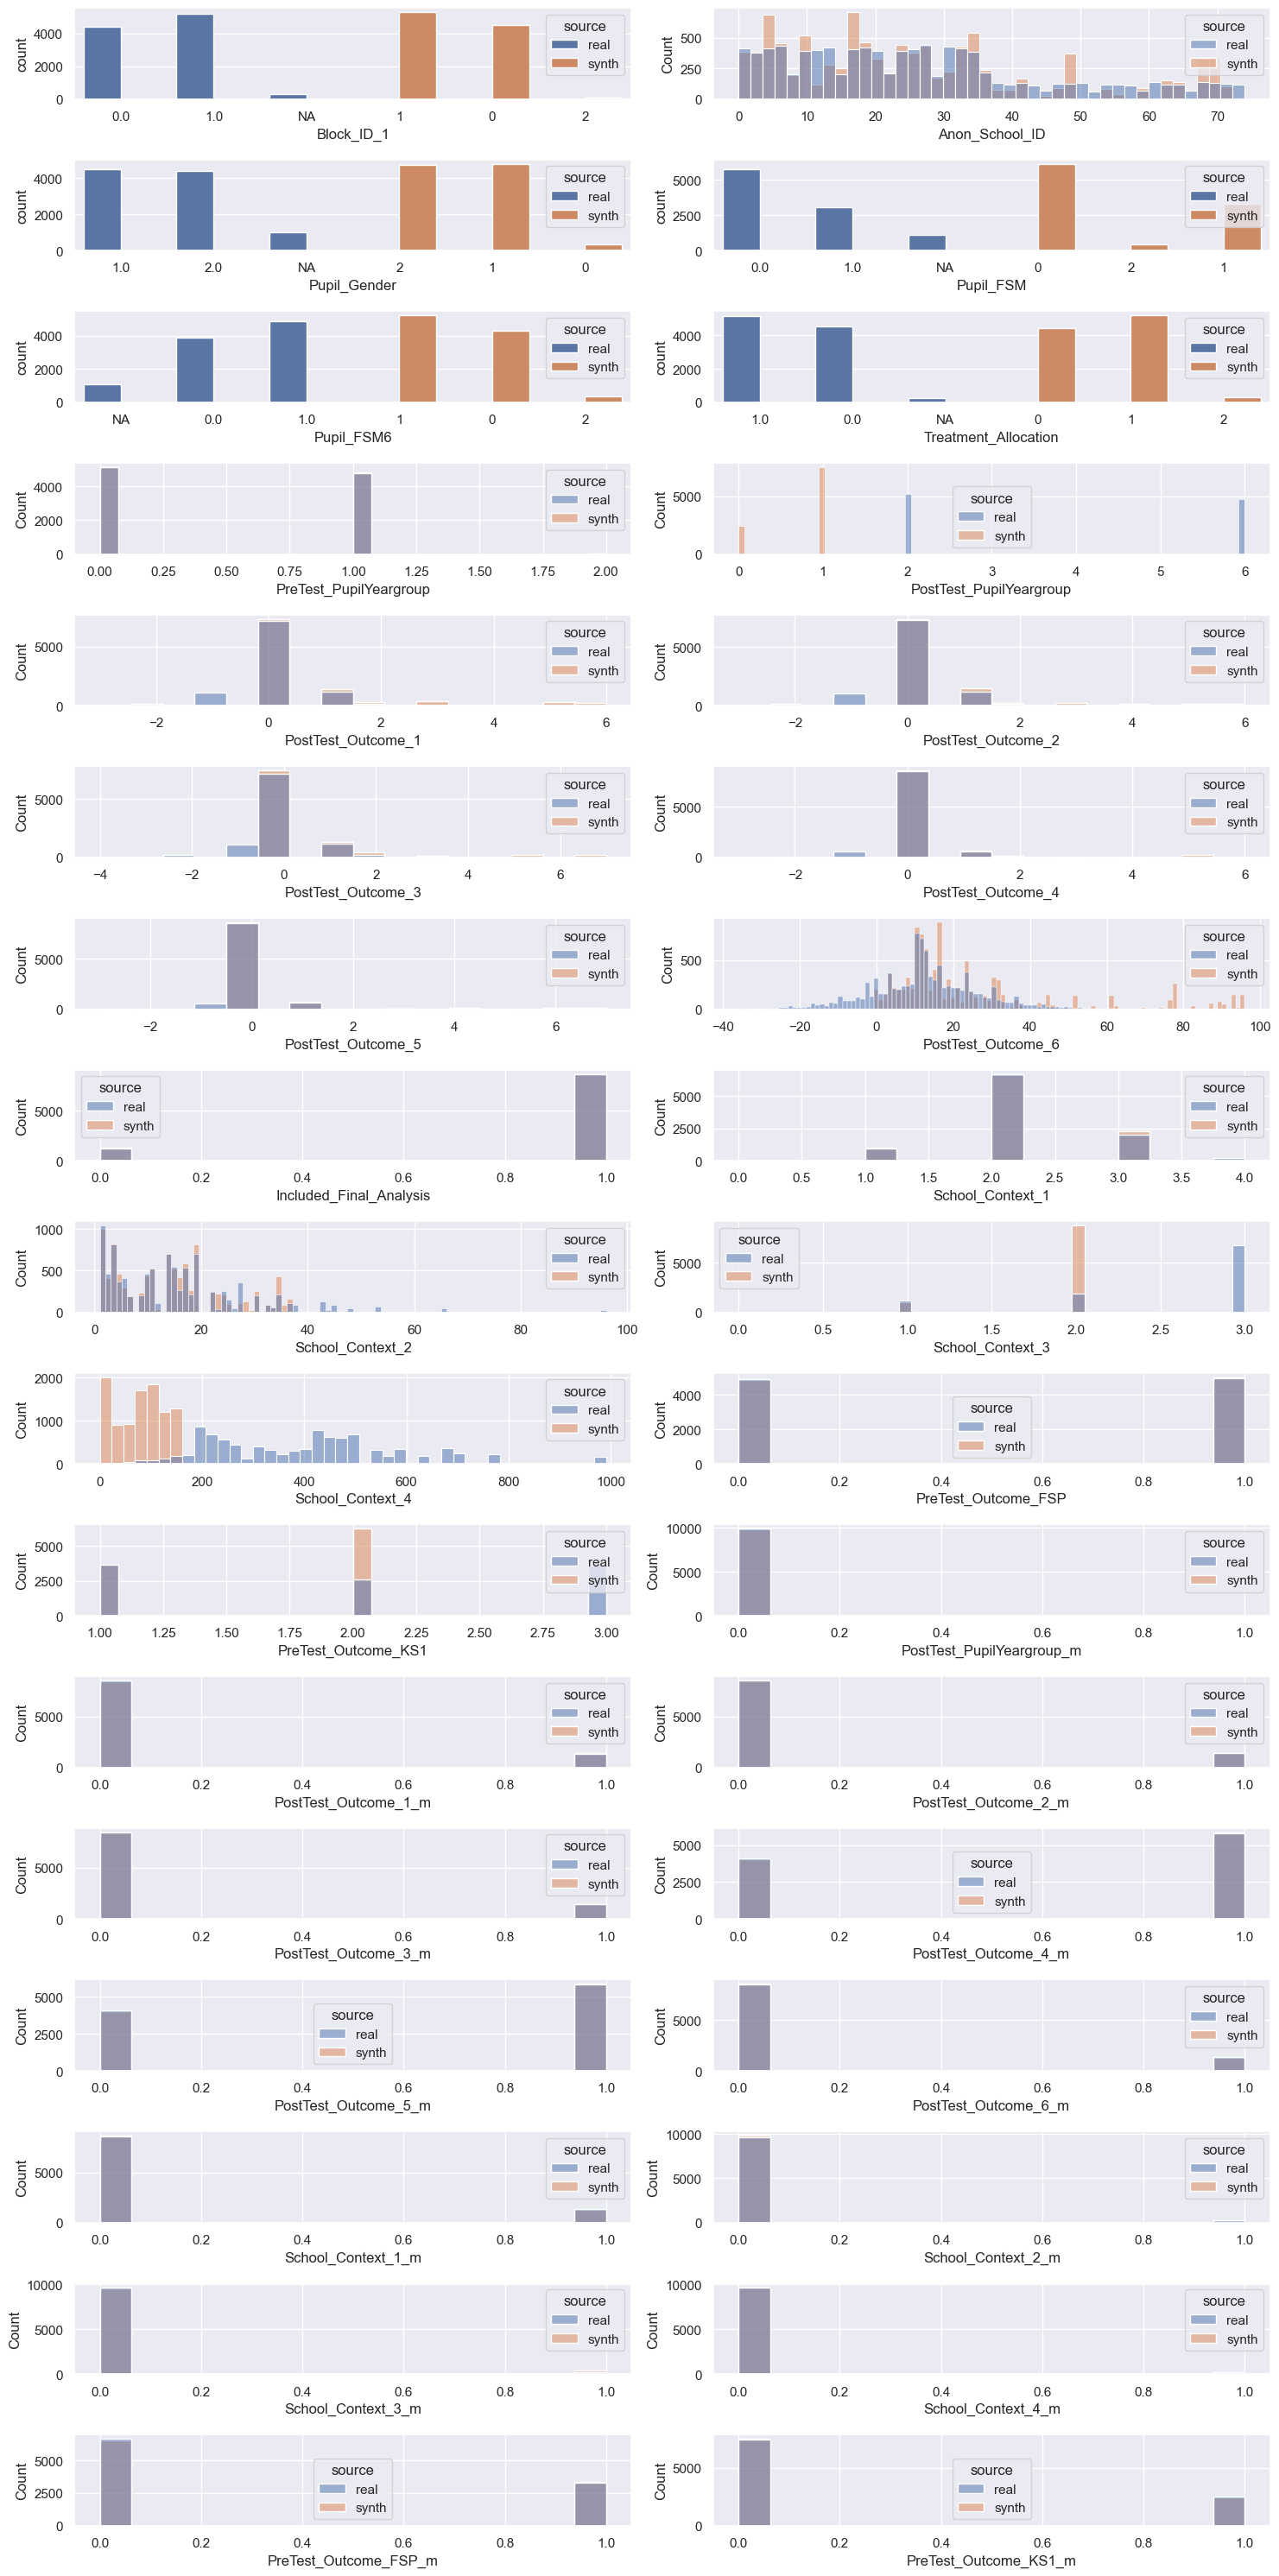

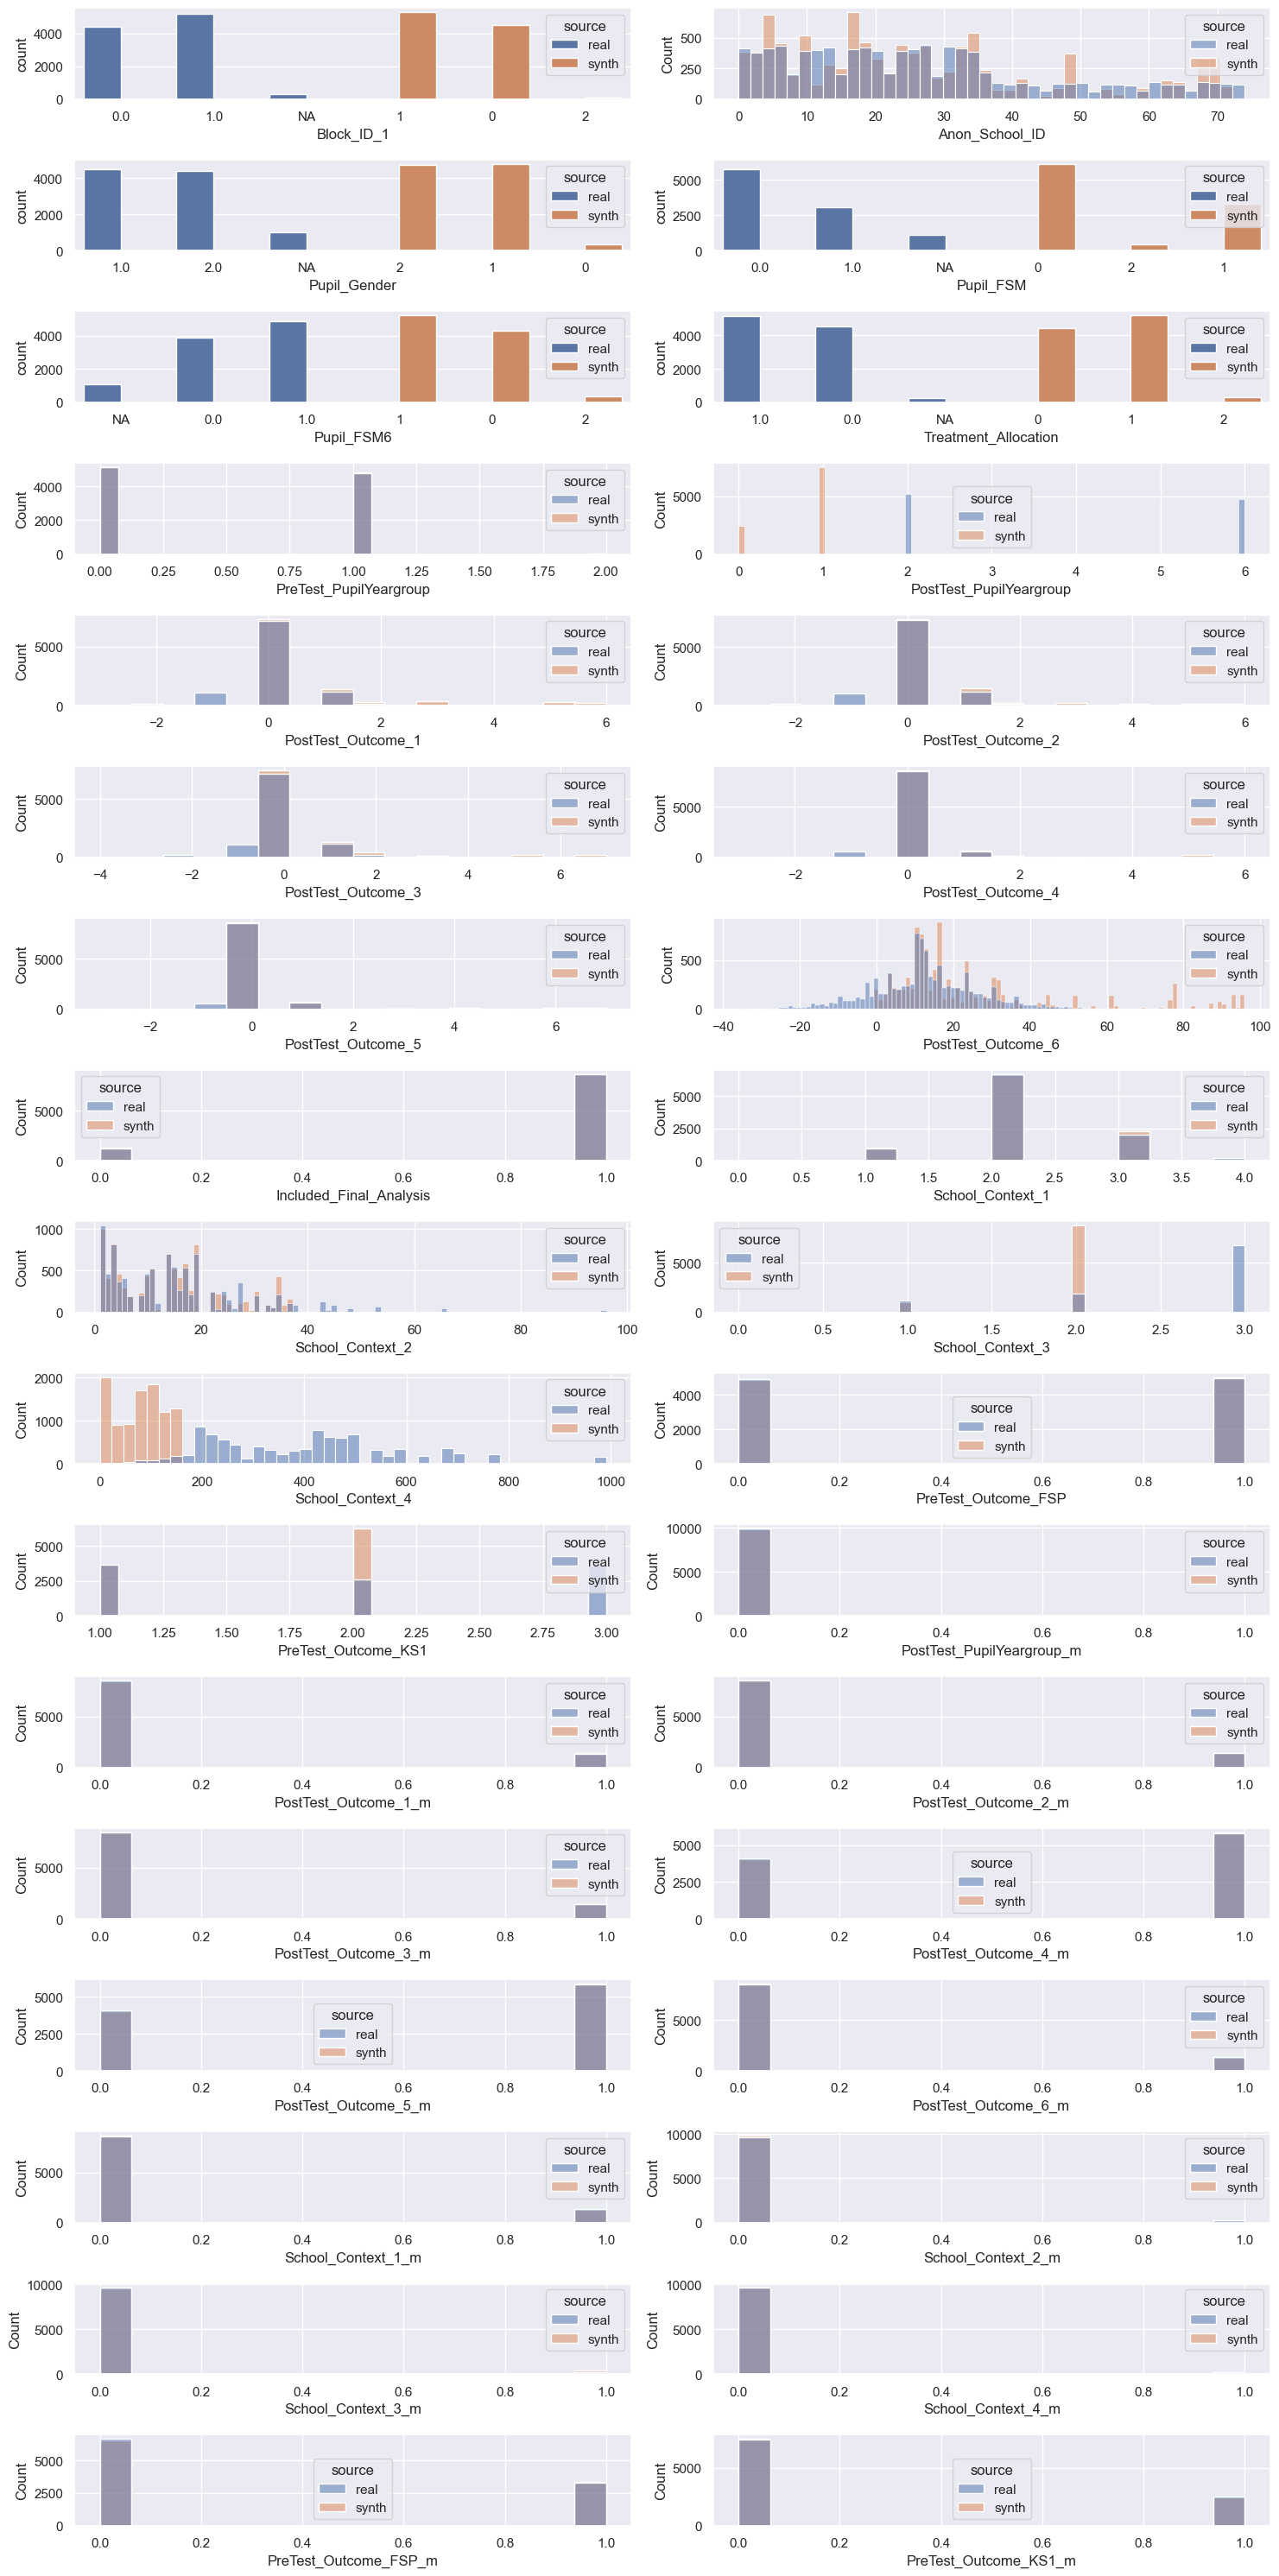

In [16]:
mst_evaluator.plot_histograms(figsize=(15, 30))

Explore the data using these functions, and any other analysis you can think of.
- Where does the generator perform well? 
- What happens if you change the relationships that have a privacy budget allocated to them? (CLIQUES in the allocate_privacy_budget function above)
- What happens if you change the total privacy budget? (epsilon in the allocate_privacy_budget above)
- What happens if you change the number of iterations? (n_iter in the train_model function above)
- Finally, what if you produce different numbers of observations? (no_rows in the generate_data function above)


## Benchmark the MST synthetic data

Along with informal inspection of the data, there are formal metrics available to benchmark different models in terms of their privacy, utility, and fidelity. In the project, we examined a number of metrics. For the sake of time, just one is loaded below (although you can add additional metrics if you have time - see documentation here https://datasciencecampus.github.io/synthgauge/autoapi/synthgauge/metrics/index.html)

**Fidelity**
- **PMSE**: Mean-squared difference in pairwise Pearson correlation coefficients (continuous data) - Measures how well relationships between continuous variables have been preserved, by taking the difference in correlations between variables between the synthetic and original data. *(Minimise towards 0)*
- **PMSE-ratio**: Correlation ratio mean-squared difference (continuous/categorical data) - Measures how well relationships between continuous or categorical variables have been preserved, by taking the difference in correlations between variables between the synthetic and original data. *(Minimise towards 0)*
- **MAD**: Mean absolute difference of feature densities - Measures how well the distribution of individual variables has been preserved, by taking the difference in the measure of their distribution between synthetic and original data. *(Minimise towards 0)*

**Utility**
- **Classification error**: Classification comparison (difference in precision, recall, F1 scores on a classification task) - Uses the synthetic data to train a classifier, and then tests the difference in accuracy when predicting on real data. *(Minimize towards 0)*

**Privacy** 
- **Nearest neighbors**: Minimum distance nearest neighbor - A check to ensure that outliers have not been replicated in the synthetic data *(Maximise)*
- **TCAP score**: Target Correct Attributional Probability Score - The risk that a target variable can be generated given a key variable *(Minimise towards 0)*
- **Sample overlap**: Proportion of real data found in synthetic data - A straightforward check that no real observations are contained in the synthetic dataset (necessary, but not sufficient, to preserve privacy) *(Should always be 0)*




In [50]:
def tcap_test(
    original_df: pd.DataFrame, synthetic_df: pd.DataFrame, key: list, target: str
) -> pd.DataFrame:
    """
    This function calculates the tcap_score metric - which is the chance that an attacker could infer the
    true values of the target variable, if they had acess to both the true and synthetic values of the 'key' variables.
    The key variables should therefore be data that is widely available; the target should be sensitive data.

    Parameters:
        original_df (pd.DataFrame): The original dataframe containing the actual data.
        synthetic_df (pd.DataFrame): The synthetic dataframe containing the generated data.

    Returns:
        pd.DataFrame: The evaluation results as a dataframe.
    """
    evaluator = sg.Evaluator(original_df, synthetic_df)
    evaluator.add_metric(
        "tcap_score",
        key=key,
        target=target,
    )
    return evaluator.evaluate(as_df=True)

In [51]:
tcap_test(orig_df, mst_synth_data, ["Treatment_Allocation"], "PostTest_Outcome_1")

,value
tcap_score,0
